In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

os.environ['LDFLAGS'] = '-L/opt/homebrew/opt/libomp/lib'
os.environ['CPPFLAGS'] = '-I/opt/homebrew/opt/libomp/include'

In [4]:
merged_df = pd.read_csv("merged_df.csv")

# Fill NA for has_mentions_in_bio and has_url_in_bio
merged_df['has_mentions_in_bio'] = merged_df['has_mentions_in_bio'].fillna(0)
merged_df['has_url_in_bio'] = merged_df['has_url_in_bio'].fillna(0)

# Drop rows with any missing values
merged_df_clean = merged_df.dropna()
merged_df_clean

# select features and target
X = merged_df_clean.drop(columns=['kmeans_cluster', 'did', 'handle', 'first_post_body', 'bio', 'created_at', 'first_post_created_at'])
y = merged_df_clean['kmeans_cluster']

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_splits = 10
# get folds
k_folds = StratifiedKFold(n_splits=n_splits)

# define models

# logistic regression
log_reg = LogisticRegression(
    max_iter=1000
)

log_reg_bal = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

# random forest
rf = RandomForestClassifier()
rf_bal = RandomForestClassifier(
    class_weight='balanced'
)

# xgboost
xgb = XGBClassifier(
    eval_metric='aucpr'
)

# Initialize feature importance data
feature_data = {}

model_names = [
    "Logistic Regression",
    "Logistic Regression (Balanced)",
    "Random Forest",
    "Random Forest (Balanced)",
    "XGBoost",
    "XGBoost (Balanced)",
    "XGBoost (Lasso)",
    "HGB Gradient Boosting Classifier",
    "HGB Classifier (Balanced)",
    "Ensemble (Voting Classifier)",
    "Curated Ensemble",
]

fold_scores = {i:{
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC Score': [],
} for i in model_names}

y_preds = {i:[] for i in model_names}
y_vals = []

for i, (train_index, test_index) in enumerate(k_folds.split(X_scaled,y)):
    X_train_scaled = X_scaled[train_index]
    y_train = y.iloc[train_index]
    X_val_scaled = X_scaled[test_index]
    y_val = y.iloc[test_index]

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
    
    y_vals.extend(y_val.to_numpy())

    # class imbalance ratios
    scale = y_train.value_counts()[0] / y_train.value_counts()[1]
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    
    xgb_bal = XGBClassifier(
        eval_metric='aucpr',
        scale_pos_weight=scale)
    xgb_lasso = XGBClassifier(
        eval_metric='aucpr',
        scale_pos_weight=scale,
        reg_alpha=1.0  # Lasso
    )

    # Histogram Based Gradient Boosting
    hgb = HistGradientBoostingClassifier()
    hgb.fit(X_train_scaled, y_train)

    hgb_bal = HistGradientBoostingClassifier()
    hgb_bal.fit(X_train_scaled, y_train, sample_weight=sample_weights)

    # Combine into ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('lr', log_reg),
            ('lr_bal', log_reg_bal),
            ('rf', rf),
            ('rf_bal', rf_bal),
            ('xgb', xgb),
            ('xgb_bal', xgb_bal),
            ('xgb_lasso', xgb_lasso),
            ('hgb', hgb),
            ('hgb_bal', hgb_bal),
        ],
        voting='soft' # soft uses predict_proba - hard uses voting
    )

    # Ensemble with Histogram-based gradient boosting and Logistic Balanced
    curated_ensemble = VotingClassifier(
        estimators=[
            ('lr_bal', log_reg_bal),
            ('hgb_bal', hgb_bal),
            ('xgb_bal', xgb_bal),
        ],
        voting='soft' # soft uses predict_proba - hard uses voting
    )

    # define classifiers
    models = {
        "Logistic Regression": log_reg,
        "Logistic Regression (Balanced)": log_reg_bal,
        "Random Forest": rf,
        "Random Forest (Balanced)": rf_bal,
        "XGBoost": xgb,
        "XGBoost (Balanced)": xgb_bal,
        "XGBoost (Lasso)": xgb_lasso,
        "HGB Gradient Boosting Classifier": hgb,
        "HGB Classifier (Balanced)": hgb_bal,
        "Ensemble (Voting Classifier)": ensemble,
        "Curated Ensemble": curated_ensemble
    }
    print(y.value_counts(normalize=True))

    # train, predict, evaluate
    for name, model in models.items():
        print(f"\n🔍 {name} (fold {i})")

        # train
        if not isinstance(model, HistGradientBoostingClassifier):
            model.fit(X_train_scaled, y_train)

        # predict
        y_pred = model.predict(X_val_scaled)
        y_preds[name].extend(y_pred)

        # evaluate
        fold_scores[name]["Accuracy"].append(accuracy_score(y_val, y_pred))
        fold_scores[name]["Precision"].append(precision_score(y_val, y_pred, average='binary', zero_division=0))
        fold_scores[name]["Recall"].append(recall_score(y_val, y_pred, average='binary', zero_division=0))
        fold_scores[name]["F1 Score"].append(f1_score(y_val, y_pred, average='binary', zero_division=0))
        fold_scores[name]["ROC AUC Score"].append(roc_auc_score(y_val, y_pred))

        # full classification report
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))

        # Feature importance (if available)
        try:
            # Tree-based models
            if hasattr(model, "feature_importances_"): 
                importances = model.feature_importances_
            # Linear models
            elif hasattr(model, "coef_"):
                importances = model.coef_[0]
            else:
                continue  # skip if no importance measure

            feature_data[name] = importances

        except Exception as e:
            print(f"Skipping {name}: {e}")


kmeans_cluster
0    0.990817
1    0.009183
Name: proportion, dtype: float64

🔍 Logistic Regression (fold 0)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2126
           1       0.43      0.75      0.55        20

    accuracy                           0.99      2146
   macro avg       0.71      0.87      0.77      2146
weighted avg       0.99      0.99      0.99      2146


🔍 Logistic Regression (Balanced) (fold 0)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2126
           1       0.43      0.75      0.55        20

    accuracy                           0.99      2146
   macro avg       0.71      0.87      0.77      2146
weighted avg       0.99      0.99      0.99      2146


🔍 Random Forest (fold 0)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.0

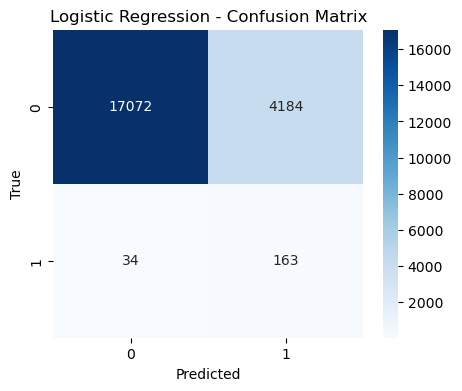

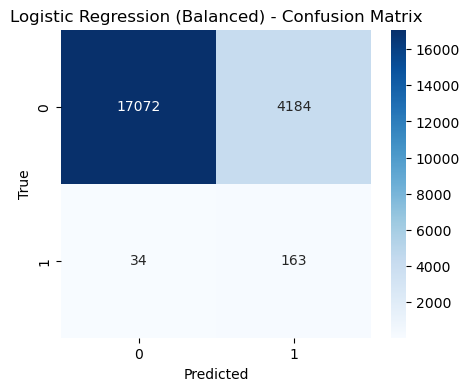

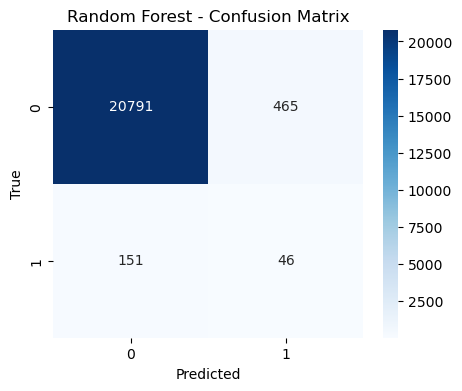

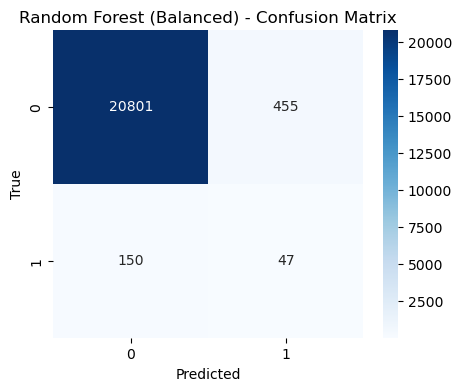

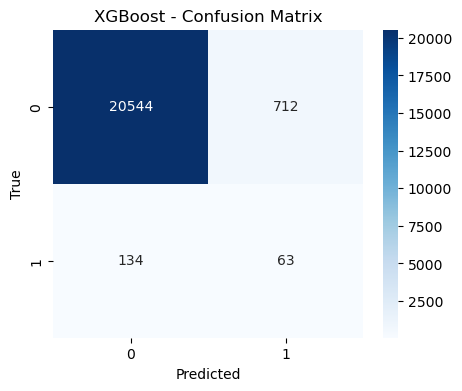

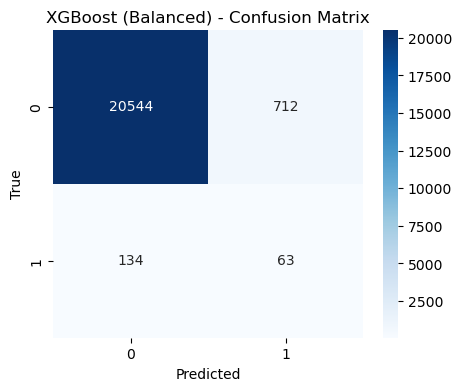

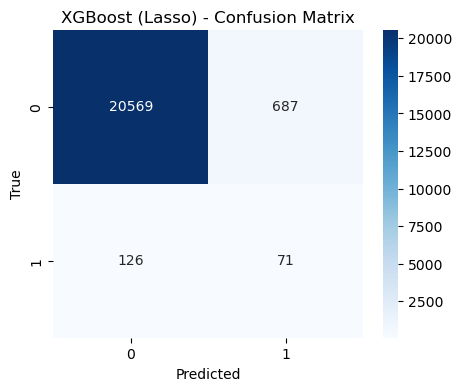

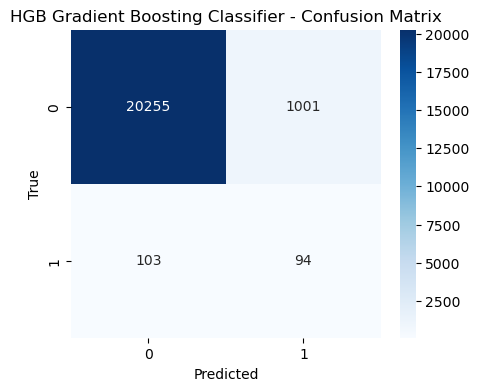

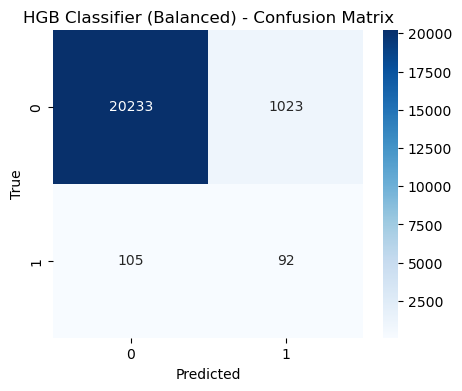

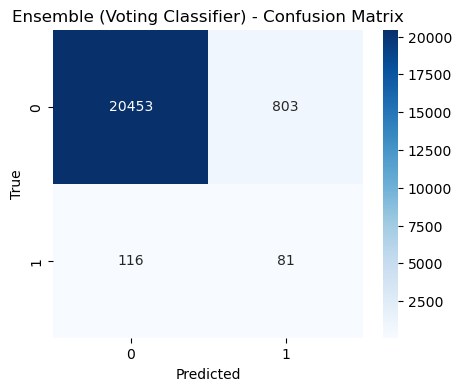

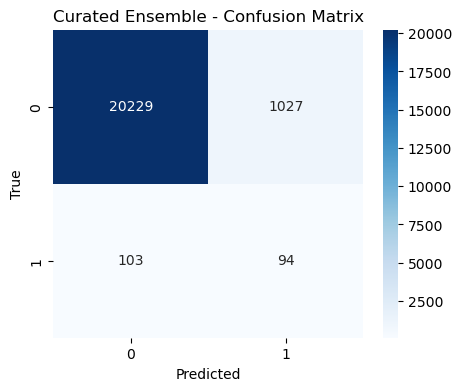

Exported to model_feature_importances.csv


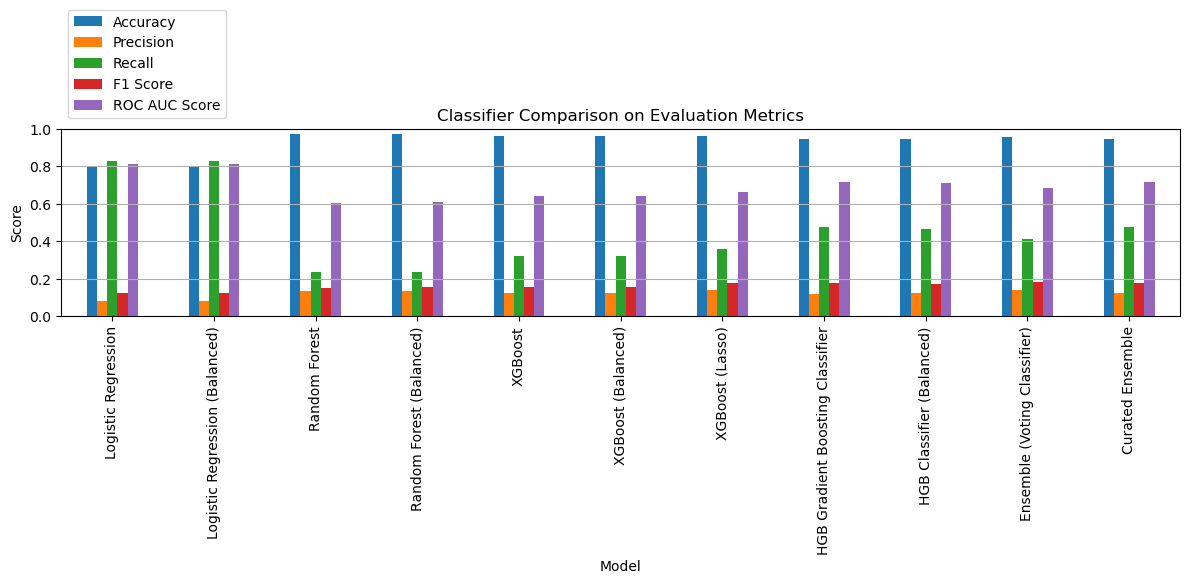

In [5]:
for name in model_names:
    # confusion matrix
    cm = confusion_matrix(y_vals, y_preds[name])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Collect metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC Score': []
}

# convert to dataframe
for model in fold_scores:
    metrics['Model'].append(model)
    metrics['Accuracy'].append(np.mean(fold_scores[model]['Accuracy'])),
    metrics['Precision'].append(np.mean(fold_scores[model]['Precision'])),
    metrics['Recall'].append(np.mean(fold_scores[model]['Recall'])),
    metrics['F1 Score'].append(np.mean(fold_scores[model]['F1 Score'])),
    metrics['ROC AUC Score'].append(np.mean(fold_scores[model]['ROC AUC Score']))
metrics_df = pd.DataFrame(metrics)

# convert feature importances to dataFrame
feature_df = pd.DataFrame(feature_data, index=X.columns)

# sort columns
feature_df = feature_df.sort_index()

# export
feature_df.to_csv("model_feature_importances.csv")
print("Exported to model_feature_importances.csv")

# plot
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title("Classifier Comparison on Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.grid(axis='y')
ax.legend(loc='lower left', bbox_to_anchor=(0, 1.02), ncol=1)
plt.tight_layout()
plt.show()

In [17]:
# Drop rows with any missing values
merged_df_clean = merged_df.dropna()
merged_df_clean

# select features and target
X = merged_df_clean.drop(columns=['kmeans_cluster', 'did', 'handle', 'first_post_body', 'bio', 'created_at', 'first_post_created_at'])
y = merged_df_clean['kmeans_cluster']

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_resample, y_train_resample)
y_pred = logistic_regression.predict(X_test)

# full classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

xgboost = XGBClassifier(eval_metric='aucpr')
xgboost.fit(X_train_resample, y_train_resample)
y_pred = xgboost.predict(X_test)

# full classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.89      4252
           1       0.04      0.87      0.07        39

    accuracy                           0.80      4291
   macro avg       0.52      0.83      0.48      4291
weighted avg       0.99      0.80      0.88      4291

ROC AUC Score: 0.8333574547121114

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4252
           1       0.08      0.28      0.12        39

    accuracy                           0.96      4291
   macro avg       0.54      0.63      0.55      4291
weighted avg       0.98      0.96      0.97      4291

ROC AUC Score: 0.626091492389705
